<a href="https://colab.research.google.com/github/anpept/Redes_Neuronales/blob/master/ArteVGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Red Neuronal preentrenada usando el dataset de imágenes de piezas de Arte. Se usa la red VGG16.

Esta red está desarrollada para reconocer distintos tipos de arte usando para ello una red preentrenada con los pesos del modelo *imagenet* . En concreto, clasifica entre pinturas, dibujos, grabados, esculturas e iconografías. Primero se debe montar nuestro sistema de archivos de Google Drive.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Se comprueba que se tiene acceso a los datos mostrando una imagen.

drawings  engraving  iconography  painting  sculpture


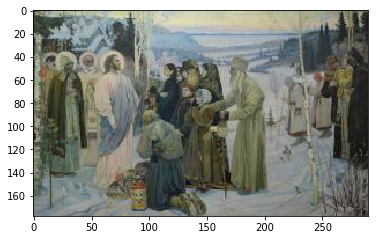

In [0]:
!ls "/content/drive/My Drive/Colab img/dataset/Arte/training_set"

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/content/drive/My Drive/Colab img/dataset/Arte/training_set/painting/1959.jpg', 'r')
imshow(np.asarray(pil_im))

Esta es la comprobación de que tenemos disponible un GPU.

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

## Creación del Modelo

Primero, se importan las librerías necesarias y se crean los generadores (un generador para el entrenamiento y otro para la validación). Estos se encargarán de alimentar de imágenes la red, y además, transforma un gran número de las imágenes disponibles para el entrenamiento en versiones diferentes. Esta técnica denominada *data augmentatio* se usa para evitar el sobreentrenamiento. 
Keras pone a disposición la arquitectura VGG16. Se creará esta red indicándole que no incluya la capa de salida y que cargue los pesos del modelo *imagenet*. El siguiente paso es congelar los pesos de la red para que no se modifiquen durante el entrenamiento.

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import keras
from time import time


# DATA SOURCE --------------------------------------------------

batch_size = 32

train_data_dir = '/content/drive/My Drive/Colab img/dataset/Arte/training_set'
validation_data_dir = '/content/drive/My Drive/Colab img/dataset/Arte/validation_set'

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

# MODEL --------------------------------------------------

from keras.applications.vgg16 import VGG16

#con include_top no se usa la capa densa. Se creará más adelante.
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#congelamos los pesos de la red vgg.
for layers in vgg_conv.layers:
  layers.trainable = False

print(vgg_conv.summary())


Found 7719 images belonging to 5 classes.
Found 798 images belonging to 5 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

Ahora se crearán las capas de salida que se colocarán en la salida de la red VGG16. Estás capas sí serán entrenables.

In [0]:
#Creación y adición de las capas densas al final
densa=Flatten()(vgg_conv.output)
densa=Dense(512, activation='relu')(densa)
densa=Dropout(0.5)(densa)
densa=Dense(5, activation='softmax')(densa)

model=Model(inputs=vgg_conv.inputs, outputs=densa)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Entrenamiento

Llegados a este punto, comienza el entrenamiento de la red durante 15 épocas.

In [0]:
epochs = 15

snn = model.fit_generator(
        train_generator,
        steps_per_epoch=242, #total_datos/lote => 7719/32
        epochs=epochs, 
        validation_data=validation_generator,
        validation_steps=25, #total_datos/lote => 798/32
)

Epoch 1/15
103/242 [===========>..................] - ETA: 14:57 - loss: 3.4216 - acc: 0.5941

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


165/242 [===================>..........] - ETA: 8:13 - loss: 2.3787 - acc: 0.6555

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6029312 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1311848 bytes but only got 785. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 8. 
  warnings.warn(str(msg))


242/242 [==============================] - 1621s 7s/step - loss: 1.7982 - acc: 0.6997 - val_loss: 0.9216 - val_acc: 0.6892
Epoch 2/15
242/242 [==============================] - 152s 628ms/step - loss: 0.5087 - acc: 0.8111 - val_loss: 0.5005 - val_acc: 0.8233
Epoch 3/15
242/242 [==============================] - 153s 633ms/step - loss: 0.4237 - acc: 0.8452 - val_loss: 0.5143 - val_acc: 0.8120
Epoch 4/15
242/242 [==============================] - 155s 640ms/step - loss: 0.3997 - acc: 0.8543 - val_loss: 0.4700 - val_acc: 0.8383
Epoch 5/15
242/242 [==============================] - 153s 632ms/step - loss: 0.3613 - acc: 0.8622 - val_loss: 0.3348 - val_acc: 0.8722
Epoch 6/15
242/242 [==============================] - 153s 633ms/step - loss: 0.3330 - acc: 0.8746 - val_loss: 0.5219 - val_acc: 0.8246
Epoch 7/15
242/242 [==============================] - 153s 634ms/step - loss: 0.3290 - acc: 0.8771 - val_loss: 0.4375 - val_acc: 0.8371
Epoch 8/15
242/242 [==============================] - 155s 64

##Resultados

Después de 15 épocas, se puede ver que la precisión del entrenamiento ha ido aumentando. Sin embargo, la precisión de la validación ha sido variable, pero no tanto como con la red que no usa el modelo preentrenado ( https://github.com/anpept/Redes_Neuronales/blob/master/Arte.ipynb ). Con este modelo se logra una precisión en el entrenamiento del 90.96% y una precisión en la validación del 88.35%.

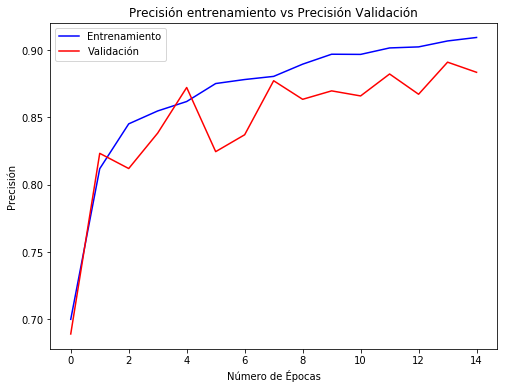

In [0]:
import matplotlib.pyplot as plt
 
plt.plot(snn.history['acc'],'b')  
plt.plot(snn.history['val_acc'],'r')  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Número de Épocas")  
plt.ylabel("Precisión")  
plt.title("Precisión entrenamiento vs Precisión Validación")  
plt.legend(['Entrenamiento','Validación'])

plt.show()

La pérdida en el entrenamiento ha ido descendiendo a medida que se sucedían las épocas.  Y la pédida en la validación es más estable que con la red que no usa el modelo VGG16 preentrenado.

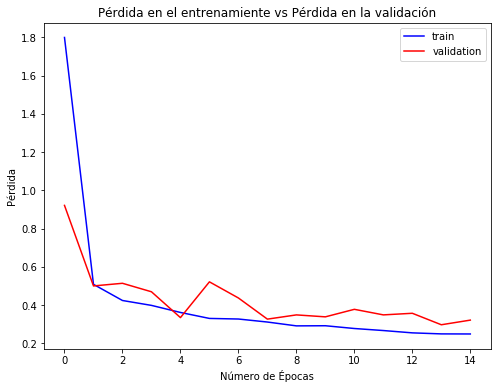

In [0]:
plt.figure(1)  
plt.plot(snn.history['loss'],'b')  
plt.plot(snn.history['val_loss'],'r')  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Número de Épocas")  
plt.ylabel("Pérdida")  
plt.title("Pérdida en el entrenamiente vs Pérdida en la validación")  
plt.legend(['train','validation'])

plt.show()

# Test

A continuación, se crea un pequeño test. Primero, se crea un generador con las imagenes de test y se hacen las predicciones con la red ya entrenada. Luego, se extrae la salida de la red y se le aplica la etiqueta que le corresponde.

In [0]:
test_data_dir='/content/drive/My Drive/Colab img/dataset/Arte/test_set'

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
  test_data_dir,
  target_size=(224,224),
  batch_size=15,  
  class_mode='categorical',
  shuffle=False)

test_generator.reset()

predicciones = model.predict_generator(test_generator, verbose=1, steps=1)
predicciones_indices = np.argmax(predicciones,axis=1)

etiquetas = (test_generator.class_indices)
etiquetas = dict((v,k) for k,v in etiquetas.items())
predicciones_etiquetas=[etiquetas[k] for k in predicciones_indices]


Found 15 images belonging to 5 classes.
1/1 [==============================] - 2s 2s/step


La salida debería ser: 

['drawings',
 'drawings',
 'drawings',
 'engraving',
 'engraving',
 'engraving',
 'iconography',
 'iconography',
 'iconography',
 'painting',
 'painting',
 'painting',
 'sculpture',
 'sculpture',
 'sculpture']
 
 Como se puede ver, la red se ha equivocado al clasificar una de las imágenes. Bastante mejor que con la red que no usa el modelo VGG16.

In [0]:
predicciones_etiquetas

['sculpture',
 'drawings',
 'drawings',
 'engraving',
 'engraving',
 'engraving',
 'iconography',
 'iconography',
 'iconography',
 'painting',
 'painting',
 'painting',
 'sculpture',
 'sculpture',
 'sculpture']